In [1]:
MAKE_BOOK_FIGURES=True

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def set_notebook_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings - using default sizes
        'font.family': 'serif',
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        
        # Line and marker settings
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout settings
        'figure.constrained_layout.use': True,
        
        # Remove only top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional settings
        'figure.autolayout': True,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)

def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
else:
    set_notebook_style()

make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

(bayesian_linear_regression_example)=
# Bayesian Linear Regression

We demonstrate how epistemic uncertainty can be estimated using Bayesian linear regression.

## Example (Linear)
Let's start with a simple example where we must find a linear fit.
Here is some synthetic data:

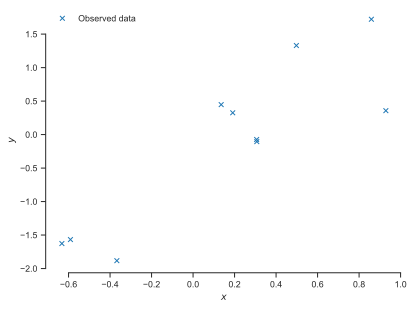

In [2]:
np.random.seed(12345)

num_obs = 10
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
sigma_true = 0.5
y = w0_true + w1_true * x + sigma_true * np.random.randn(num_obs)

fig, ax = plt.subplots()
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Let's also copy-paste the code for creating design matrices for the three generalized linear models we have considered so far:

In [3]:
def get_polynomial_design_matrix(x, degree):
    """Return the polynomial design matrix of ``degree`` evaluated at ``x``.
    
    Arguments:
    x      -- A 2D array with only one column.
    degree -- An integer greater than zero.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    cols = []
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

def get_fourier_design_matrix(x, L, num_terms):
    """Fourier expansion with ``num_terms`` cosines and sines.
    
    Arguments:
    x          --  A 2D array with only one column.
    L          --  The "length" of the domain.
    num_terms  --  How many Fourier terms do you want.
                   This is not the number of basis
                   functions you get. The number of basis functions
                   is 1 + num_terms / 2. The first one is a constant.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(int(num_terms / 2)):
        cols.append(np.cos(2 * (i+1) * np.pi / L * x))
        cols.append(np.sin(2 * (i+1) * np.pi / L * x))
    return np.hstack(cols)
                    
def get_rbf_design_matrix(x, x_centers, ell):
    """Radial basis functions design matrix.
    
    Arguments:
    x        --  The input points on which you want to evaluate the
                 design matrix.
    x_center --  The centers of the radial basis functions.
    ell      --  The lengthscale of the radial basis function.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

We saw that for Gaussian likelihood and weight prior, the posterior of the weights is Gaussian:
$$
p(\mathbf{w}|\mathbf{x}_{1:n},\mathbf{y}_{1:n}, \sigma, \alpha) = \mathcal{N}\left(\mathbf{w}|\mathbf{m}, \mathbf{S}\right),
$$
where
$$
\mathbf{S} = \left(\sigma^{-2}\mathbf{\Phi}^T\mathbf{\Phi}+\alpha\mathbf{I}\right)^{-1},
$$
and
$$
\mathbf{m} = \sigma^{-2}\mathbf{S}\Phi^T\mathbf{y}_{1:n}.
$$
Let's write some code that finds the posterior weight mean vector $\mathbf{m}$ and the posterior weight covariance matrix $\mathbf{S}$:

In [4]:
import scipy

def find_m_and_S(Phi, y, sigma2, alpha):
    """Return the posterior mean and covariance of the weights
    of a Bayesian linear regression problem.
    
    Arguments:
    Phi    -- The design matrix.
    y      -- The observed targets.
    sigma2 -- The noise variance.
    alpha  -- The prior weight precision.
    """
    A = (
        Phi.T @ Phi / sigma2
        + alpha * np.eye(Phi.shape[1])
    )
    L = scipy.linalg.cho_factor(A)
    m = scipy.linalg.cho_solve(
        L,
        Phi.T @ y / sigma2
    )
    S = scipy.linalg.cho_solve(
        L,
        np.eye(Phi.shape[1])
    )
    return m, S

Let's apply this to the synthetic dataset.

In [5]:
import scipy.stats as st

degree = 1
Phi = get_polynomial_design_matrix(x[:, None], degree)

# We need to pick variance by hand for now (here I am using the true one)
sigma2 = 0.1 ** 2
# We also need to pick the regularization parameter by hand:
alpha = 0.1

# Here is the prior for the weights as a distribution:
w_prior = st.multivariate_normal(
    mean=np.zeros(degree+1),
    cov=np.eye(degree+1) / alpha
)

# Get the posterior mean and covariance for the weights:
m, S = find_m_and_S(Phi, y, sigma2, alpha)
# The posterior of the weights as a distribution:
w_post = st.multivariate_normal(mean=m, cov=S)

print(f"Posterior mean w: {m}")
print("Posterior covariance w:")
print(S)

Posterior mean w: [-0.43104689  1.97951928]
Posterior covariance w:
[[ 0.00109865 -0.00060371]
 [-0.00060371  0.00369096]]


Now let's plot contours of the prior and the posterior.

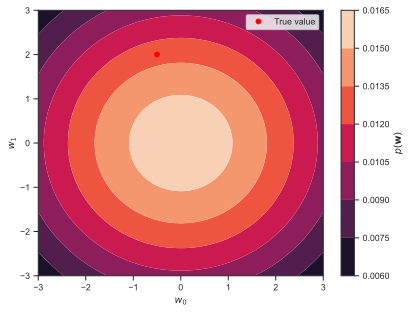

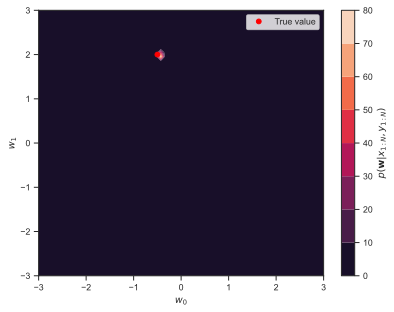

In [7]:
# Grid on w
ws = np.linspace(-3.0, 3.0, 64)
W1, W2 = np.meshgrid(ws, ws)
w_all = np.hstack(
    [
        W1.flatten()[:, None],
        W2.flatten()[:, None]
    ]
)

# Prior contour
W_prior_pdf = w_prior.pdf(w_all).reshape(W1.shape)
fig, ax = plt.subplots()
c = ax.contourf(W1, W2, W_prior_pdf)
ax.plot(w0_true, w1_true, 'ro', label='True value');
plt.legend(loc='best')
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$')
plt.colorbar(c, label='$p(\mathbf{w})$');

# Postrior contour
W_post_pdf = w_post.pdf(w_all).reshape(W1.shape)
fig, ax = plt.subplots()
c = ax.contourf(W1, W2, W_post_pdf)
ax.plot(w0_true, w1_true, 'ro', label='True value');
plt.legend(loc='best')
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$')
plt.colorbar(c, label='$p(\mathbf{w}|x_{1:N}, y_{1:N})$');

In this case, we see that the posterior collapses to the actual value of the weights.

Let's visualize some prior samples of the weights.
What we do below is just sampling from the prior of the weights and drawing the line that corresponds to each sample. Notice that the lines are all over the place. Some have a positive slope. Some have a negative slope. Some cut the x-axis, and some don't. That's fine. We have so much uncertainty because we have yet to see the data.

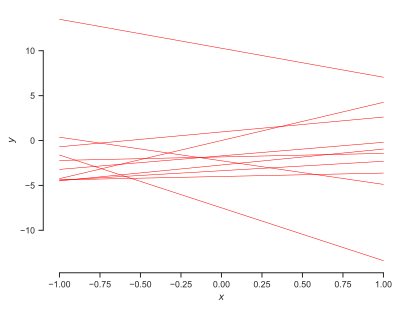

In [8]:
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)

fig, ax = plt.subplots()
for _ in range(10):
    # Here is how you can sample from the prior
    w_sample = w_prior.rvs()
    yy_sample = Phi_xx @ w_sample
    ax.plot(xx, yy_sample, 'r', lw=0.5)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
sns.despine(trim=True);

Now, let's do the same thing, but instead of sampling the weights from the prior, let's test them from the posterior.
Notice that there is much less (epistemic) uncertainty now that we are considering the data.

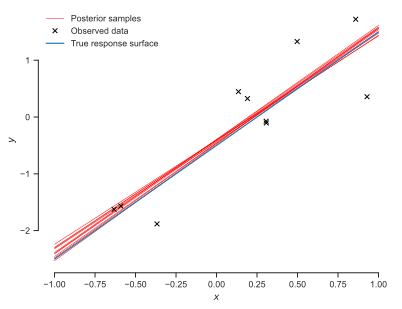

In [9]:
yy_true = w0_true + w1_true * xx

fig, ax = plt.subplots()

for _ in range(10):
    # Here is how you can sample from the posterior
    w_sample = w_post.rvs()
    yy_sample = np.dot(Phi_xx, w_sample)
    ax.plot(xx, yy_sample, 'r', lw=0.5)

ax.plot([], [], 'r', lw=0.5, label="Posterior samples")
ax.plot(x, y, 'kx', label='Observed data')
ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

### Questions

+ Rerun the code cells above with a very small $\alpha$. What happens?
+ Rerun the code cells above with a very big $\alpha$. What happens?
+ Fix $\alpha$ to $5$ and rerun the code cells above with a minimal and very big value for $\sigma$. What happens in each case?

## Example (Quadratic)

Let's repeat what we did above with a quadratic example.
Here are some synthetic data:

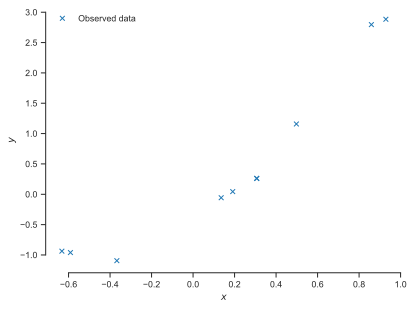

In [10]:
np.random.seed(12345)

num_obs = 10
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
w2_true = 2.0
sigma_true = 0.1

y = (
    w0_true
    + w1_true * x
    + w2_true * x ** 2
    + sigma_true * np.random.randn(num_obs)
)

fig, ax = plt.subplots()
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Here is how we fit a $7$ degree polynomial:

In [11]:
# Parameters
degree = 7
sigma2 = 0.1 ** 2
alpha = 5.0

# Weight prior
w_prior = st.multivariate_normal(
    mean=np.zeros(degree+1),
    cov=np.eye(degree+1) / alpha
)

# Design matrix
Phi = get_polynomial_design_matrix(
    x[:, None],
    degree
)

# Fit
m, S = find_m_and_S(Phi, y, sigma2, alpha)

# Weight posterior
w_post = st.multivariate_normal(mean=m, cov=S)

print(f"Posterior mean w: {m}")
print("Posterior covariance w:")
print(S)

Posterior mean w: [-0.3643298   1.87327178  1.3288042   0.36050275  0.53776681 -0.08624885
  0.01954992 -0.27053602]
Posterior covariance w:
[[ 0.00315175 -0.00321667 -0.01024025  0.00532315  0.00146701  0.002684
   0.0015408   0.00126902]
 [-0.00321667  0.01988414  0.00953384 -0.03609637  0.00683632 -0.00674544
   0.00546342  0.00094567]
 [-0.01024025  0.00953384  0.07422345 -0.00730177 -0.05608467 -0.00414937
  -0.02267156 -0.00105223]
 [ 0.00532315 -0.03609637 -0.00730177  0.13140085 -0.01689961 -0.04527107
  -0.01778471 -0.02776183]
 [ 0.00146701  0.00683632 -0.05608467 -0.01689961  0.15068265 -0.02540831
  -0.0373079  -0.02522585]
 [ 0.002684   -0.00674544 -0.00414937 -0.04527107 -0.02540831  0.15658807
  -0.03130496 -0.03742464]
 [ 0.0015408   0.00546342 -0.02267156 -0.01778471 -0.0373079  -0.03130496
   0.1608574  -0.03536093]
 [ 0.00126902  0.00094567 -0.00105223 -0.02776183 -0.02522585 -0.03742464
  -0.03536093  0.1599182 ]]


Let's visualize some samples from the prior:

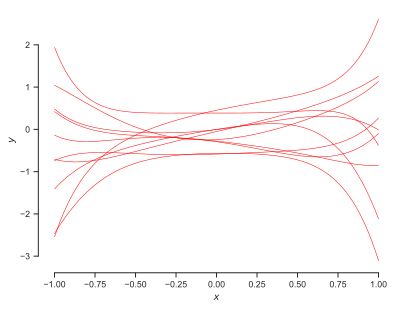

In [12]:
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)

fig, ax = plt.subplots()

for _ in range(10):
    w_sample = w_prior.rvs()
    yy_sample = Phi_xx @ w_sample
    ax.plot(xx, yy_sample, 'r', lw=0.5)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
sns.despine(trim=True);

Let's visualize some samples from the posterior:

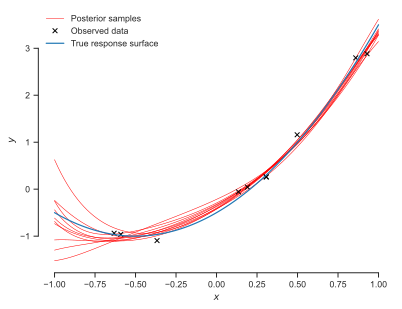

In [13]:
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2

fig, ax = plt.subplots()

for _ in range(10):
    w_sample = w_post.rvs()
    yy_sample = np.dot(Phi_xx, w_sample)
    ax.plot(xx, yy_sample, 'r', lw=0.5)

ax.plot([], [], 'r', lw=0.5, label="Posterior samples")
ax.plot(x, y, 'kx', label='Observed data')
ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

### Questions

+ Rerun the code cells above with a very small $\alpha$. What happens?
+ Rerun the code cells above with a very big $\alpha$. What happens?
+ Fix $\alpha$ to $5$ and rerun the code cells above with a very small and very big value for $\sigma$. What happens in each case?